# Degenerate states tutorial and demo
06/08/21

- With updated AFBLM function, correctly including degenerate states. (See [commit 2153b31](https://github.com/phockett/ePSproc/commit/2153b3139a3b7cabad8e14695e0981b4303683db).)

03/08/21

When working with matrix elements for degenerate states, there are some additional considerations, which are explored herein. (For matrix element background, see [the advanced tutorial](ePS_adv_tutorial_080520.html).)

## Background - degenerate orbitals in ePolyScat (ePS)

For degenerate states, ePS outputs additional sets of matrix elements, identified by the index `it`. In some cases, simply working with a single set of matrix elements (i.e. selecting `it=1`) is sufficient; in other cases one needs to use all sets, or set a degeneracy variable.

Various cases are explored below.

## tl;dr summary

In the current package (v1.3-dev) the following applies for degenerate states (multiple `it` components in ePS output) using the geometric routines :

- MF calculations with `mfpadNumeric()` or `MFBLM()` class routines:
  - Give correct PADs and $\beta_{LM}$ parameters for each component, hence using a single component is normally sufficient.
  - May give incorrect cross-sections for `it>1` components (due to extra phase rotations).
  - May be missing a degeneracy factor in the scaled cross-section outputs.
  - May required additional (manual) symmetrization for specific cases (e.g. sum over components).
- AF/LF $\beta_{LM}$ calculations with `AFBLM()` class routine:
  - Give correct PADs and $\beta_{LM}$ for each component.
  - Give correct cross-secions (including degeneracy) with default settings (`degenDrop=True`) (as of [commit 2153b31](https://github.com/phockett/ePSproc/commit/2153b3139a3b7cabad8e14695e0981b4303683db)).
  - May give incorrect cross-sections for `it>1` components (due to extra phase rotations).

## Setup

Load modules & test dataset.

In [1]:
# For module testing, include path to module here, otherwise use global installation
# local = True

# if local:
#     import sys
#     if sys.platform == "win32":
#         modPath = r'D:\code\github\ePSproc'  # Win test machine
#         winFlag = True
#     else:
#         modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
#         winFlag = False

#     sys.path.append(modPath)

# Base
import epsproc as ep

# Class dev code
from epsproc.classes.multiJob import ePSmultiJob
from epsproc.classes.base import ePSbase

* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 
* pyevtk not found, VTK export not available. 


In [2]:
import matplotlib.pyplot as plt

# Set some plot options (optional, but required for Holoviews backend)
# ep.plot.hvPlotters.setPlotters()

In [3]:
# FOR XARRAY VERSION TESTING ONLY (v0.13, v0.15)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set path for ePSproc test data, available from https://github.com/phockett/ePSproc/tree/master/data
# Here this is assumed to be on the epsproc path

from pathlib import Path
import os

epDemoDataPath = Path(ep.__path__[0]).parent/'data'

In [5]:
# Set path
dataPath = os.path.join(epDemoDataPath, 'photoionization', 'n2_multiorb')

# Instantiate class object.
# Minimally this needs just the dataPath, if verbose = 1 is set then some useful output will also be printed.
data = ePSbase(dataPath, verbose = 1)

# ScanFiles() - this will look for data files on the path provided, and read from them.
data.scanFiles()


*** Job orb6 details
Key: orb6
Dir /home/paul/github/ePSproc/data/photoionization/n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_1pu_0.1-50.1eV, orbital A2',
    'event': ' N2 A-state (1piu-1)',
    'orbE': -17.09691397835426,
    'orbLabel': '1piu-1'}

*** Job orb5 details
Key: orb5
Dir /home/paul/github/ePSproc/data/photoionization/n2_multiorb, 1 file(s).
{   'batch': 'ePS n2, batch n2_3sg_0.1-50.1eV, orbital A2',
    'event': ' N2 X-state (3sg-1)',
    'orbE': -17.34181645456815,
    'orbLabel': '3sg-1'}


## Example case - $N_2$ orb6 ($\Pi_{u}$)

From the demo data, we can look at the $\Pi_{u}$ case. For orbital visualisation, see https://www.chemtube3d.com/orbitalsnitrogen/ for instance, or plotting code below (in development!).

### Matrix elements

Firstly, let's take a look at the raw matrix elements, with some subselection for clarity.

In [6]:
k = 'orb6'
data.matEtoPD(keys = k, selDims = {'Type':'L'}, Erange = [1.0,5.0], thres=1e-2)


*** 1piu-1
Matrix element table, threshold=0.01, data type=complex128.


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Eke                                        1.1                 2.1  \
Cont Targ Total it l m  mu                                           
DG   PU   PU    1  2 -2  1 -1.323692+2.405362j  2.059722+1.896683j   
                      2 -1 -1.323692+2.405362j  2.059722+1.896683j   
                   4 -2  1  0.034025+0.018395j  0.025330-0.054052j   
                      2 -1  0.034025+0.018395j  0.025330-0.054052j   
                2  2 -2  1 -2.405362-1.323692j -1.896683+2.059722j   
                      2 -1  2.405362+1.323692j  1.896683-2.059722j   
                   4 -2  1 -0.018395+0.034025j  0.054052+0.025330j   
                      2 -1  0.018395-0.034025j -0.054052-0.025330j   
PG   PU   SU    1  2 -1  0 -1.565351-4.060912j -3.956866+1.117559j   
                      1  0 -1.565351-4.060912j -3.956866+1.117559j   
                   4 -1  0 -0.072045+0.015315j  0.038145+0.092675j   
                      1  0 -0.072045+0.015315j  0.038145+0.092675j   
                2  2 -1  0  4.060912-1.565351j -1.117559-3.956866j   
                      1  0 -4.060912+1.565351j  1.117559+3.956866j   
                   4 -1  0 -0.015315-0.072045j -0.092675+0.038145j   
                      1  0  0.015315+0.072045j  0.092675-0.038145j   
SG   PU   PU    1  0  0 -1 -1.192084+0.664368j  0.025137+1.273682j   
                         1 -1.192084+0.664368j  0.025137+1.273682j   
                   2  0 -1  0.102868+1.101282j  1.064970+0.166844j   
                         1  0.102868+1.101282j  1.064970+0.166844j   
                   4  0 -1  0.022030+0.005773j  0.006465-0.033890j   
                         1  0.022030+0.005773j  0.006465-0.033890j   
                2  0  0 -1 -0.664368-1.192084j -1.273682+0.025137j   
                         1  0.664368+1.192084j  1.273682-0.025137j   
                   2  0 -1 -1.101282+0.102868j -0.166844+1.064970j   
                         1  1.101282-0.102868j  0.166844-1.064970j   
                   4  0 -1 -0.005773+0.022030j  0.033890+0.006465j   
                         1  0.005773-0.022030j -0.033890-0.006465j   

Eke                                        3.1                 4.1  
Cont Targ Total it l m  mu                                          
DG   PU   PU    1  2 -2  1  2.776525+0.528391j  2.804544-0.376417j  
                      2 -1  2.776525+0.528391j  2.804544-0.376417j  
                   4 -2  1 -0.023705-0.076824j -0.068247-0.073785j  
                      2 -1 -0.023705-0.076824j -0.068247-0.073785j  
                2  2 -2  1 -0.528391+2.776525j  0.376417+2.804544j  
                      2 -1  0.528391-2.776525j -0.376417-2.804544j  
                   4 -2  1  0.076824-0.023705j  0.073785-0.068247j  
                      2 -1 -0.076824+0.023705j -0.073785+0.068247j  
PG   PU   SU    1  2 -1  0 -2.146107+3.074793j -0.603062+3.285834j  
                      1  0 -2.146107+3.074793j -0.603062+3.285834j  
                   4 -1  0  0.108176+0.039526j  0.119749-0.018265j  
                      1  0  0.108176+0.039526j  0.119749-0.018265j  
                2  2 -1  0 -3.074793-2.146107j -3.285834-0.603062j  
                      1  0  3.074793+2.146107j  3.285834+0.603062j  
                   4 -1  0 -0.039526+0.108176j  0.018265+0.119749j  
                      1  0  0.039526-0.108176j -0.018265-0.119749j  
SG   PU   PU    1  0  0 -1  0.468161+1.094660j  0.621346+0.924361j  
                         1  0.468161+1.094660j  0.621346+0.924361j  
                   2  0 -1  0.966290-0.395279j  0.774437-0.643798j  
                         1  0.966290-0.395279j  0.774437-0.643798j  
                   4  0 -1 -0.023399-0.038924j -0.046039-0.031340j  
                         1 -0.023399-0.038924j -0.046039-0.031340j  
                2  0  0 -1 -1.094660+0.468161j -0.924361+0.621346j  
                         1  1.094660-0.468161j  0.924361-0.621346j  
                   2  0 -1  0.395279+0.966290j  0.643798+0.774437j  
                         1 -0.395279

Note here that there are entries for `it=1,2` in the table. For example, the first line has 

```
it 	l 	m 	mu 	
1 	2 	-2 	1 	-1.323692+2.405362j 	2.059722+1.896683j ...
```

And for `it=2` the components are:

```
it 	l 	m 	mu 	
2 	2 	-2 	1 	-2.405362-1.323692j 	-1.896683+2.059722j ...
```

In this case, we can see:

- Two `it` components, hence doubly-degenerate ($\Pi$) state.
- In complex form, the components have switched real and imaginary parts, and a sign change, $a_{1} = b_{2}$ and $b_{2} = -a_{1}$ (where the components are given as complex numbers $it_{1} = a_{1} + b_{1}j$). This can more concisely be given as $z_{2} = iz_{1}$ in standard complex number form, or $D_{2} = \Im D_{1} - i\Re D_{1}$ in matrix element notation.
- In magnitude-phase form, this relationship is a phase rotation, in this case $\phi_{1} = \phi_{2} + 3/2\pi$. (Or, equivalently, $\phi_{1} = \phi_{2} - \pi/2$ with phase wrapped back to the range $[-\pi,\pi]$.)

This is easy to confirm numerically:

In [7]:
# Quick numerical check for specific values
import numpy as np

test = np.array([-1.323692+2.405362j, -2.405362-1.323692j])

print(f"Input: \t{test}")
print(f"*i: \t{test*1j}")
print(f"Abs: \t{np.abs(test)}")
print(f"Phase: \t{np.angle(test)}")
print(f"Phase shifted: \t{np.angle(test) - 3/2 *np.pi}")
print(f"Phase shift + wrapped: \t{np.angle(test) + 1/2 *np.pi - 2*np.pi}")


Input: 	[-1.323692+2.405362j -2.405362-1.323692j]
*i: 	[-2.405362-1.323692j  1.323692-2.405362j]
Abs: 	[2.74552852 2.74552852]
Phase: 	[ 2.07387663 -2.63851235]
Phase shifted: 	[-2.63851235 -7.35090133]
Phase shift + wrapped: 	[-2.63851235 -7.35090133]


In [8]:
test[1] == 1j*test[0]

True

In [9]:
# Check inverse
test[0] == test[1]/1j

True

In this case, the two components correspond to the two $\Pi$ orbital components, which are (by convention) aligned along the $x$ and $y$ axes, hence are a similarly phase-related pair of functions. (See, for instance, [the frame rotations demo](../tests/ePSproc_frame_rotation_tests_Dec2019.html) for a similar effect with more details.) Note that the details of the relationship here is, essentially, the same as the case for symmetrized harmonics, so will generally depend on the point group of the system, and possibly on the other quantum numbers. For more on this in $N_2$ specifically, see ref. [1] below, the Supplementary Material contains the same relations for a symmetrized harmonic expansion - in that case the degenerate terms are denoted by the index $\mu$.

For using matrix elements in general, this has a few implications:

1. Choosing a specific component of a degenerate set corresponds to a specific axis choice in the molecular and/or aligned and/or lab frames of reference (MF, AF and LF respectively). 
2. The exact choice of axis implied may depend on the formalism used, and which phase-rotations are included.
3. Including all degenerate components may introduce phase issues, or not - again depending on the formalism.
4. In cases where all components should be included, but are treated without additional phase relations/rotations, it is usually the case that only a single set of parameters (value of `it`) should be used, but a degeneracy factor should be included.

In the rest of the notebook we'll look at some specific examples.

<div class="csl-bib-body" style="line-height: 1.35; ">
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em;text-align: right; width: 1em;">[1]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">C. Marceau <i>et al.</i>, “Molecular Frame Reconstruction Using Time-Domain Photoionization Interferometry,” <i>Physical Review Letters</i>, vol. 119, no. 8, p. 083401, Aug. 2017, doi: <a href="https://doi.org/10.1103/PhysRevLett.119.083401">10.1103/PhysRevLett.119.083401</a>, arXiv: <a href='https://arxiv.org/abs/1701.08432'>1701.08432</a>, figshare: <a href='https://dx.doi.org/10.6084/m9.figshare.4480349'>10.6084/m9.figshare.4480349</a></div>
  </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1103%2FPhysRevLett.119.083401&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Molecular%20Frame%20Reconstruction%20Using%20Time-Domain%20Photoionization%20Interferometry&amp;rft.jtitle=Physical%20Review%20Letters&amp;rft.volume=119&amp;rft.issue=8&amp;rft.aufirst=Claude&amp;rft.aulast=Marceau&amp;rft.au=Claude%20Marceau&amp;rft.au=Varun%20Makhija&amp;rft.au=Dominique%20Platzer&amp;rft.au=A.%20Yu.%20Naumov&amp;rft.au=P.%20B.%20Corkum&amp;rft.au=Albert%20Stolow&amp;rft.au=D.%20M.%20Villeneuve&amp;rft.au=Paul%20Hockett&amp;rft.date=2017-08&amp;rft.pages=083401&amp;rft.issn=0031-9007"></span>
</div>

## MFPADs

For the MF results, we'll look first [at the numerical case](../demos/ePSproc_class_demo_161020.html#Compute-MFPADs). This is, in a sense, more direct than computation of the $\beta_{LM}$ parameters, but also requires more careful treatment for degenerate cases and correct symmetrization of the numerical results.

TODO: generalise this...?

### Single degenerate components

Firstly, using the default code, compute MFPADs for `it=1` only.

In [10]:
# Compute MFPADs with default parameters...
data.mfpadNumeric(keys = k)

In [11]:
# Note this selects it=1 by default
data.data[k]['TX'].coords

Coordinates:
    Type     <U1 'L'
    it       int64 1
    SF       (Eke) complex128 (2.1560627+3.741674j) ... (4.4127053+1.8281945j)
    Ehv      (Eke) float64 17.2 18.2 19.2 20.2 21.2 ... 63.2 64.2 65.2 66.2 67.2
  * Phi      (Phi) float64 0.0 0.1282 0.2565 0.3847 ... 5.899 6.027 6.155 6.283
  * Theta    (Theta) float64 0.0 0.06411 0.1282 0.1923 ... 3.013 3.077 3.142
  * Eke      (Eke) float64 0.1 1.1 2.1 3.1 4.1 5.1 ... 46.1 47.1 48.1 49.1 50.1
  * Sym      (Sym) MultiIndex
  - Cont     (Sym) object 'SG' 'DG' 'PG'
  - Targ     (Sym) object 'PU' 'PU' 'PU'
  - Total    (Sym) object 'PU' 'PU' 'SU'
  * Euler    (Euler) MultiIndex
  - P        (Euler) float64 0.0 0.0 1.571
  - T        (Euler) float64 0.0 1.571 1.571
  - C        (Euler) float64 0.0 0.0 0.0
    Labels   (Euler) <U32 'z' 'x' 'y'

Summing over dims: {'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


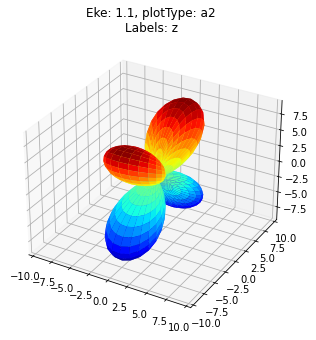

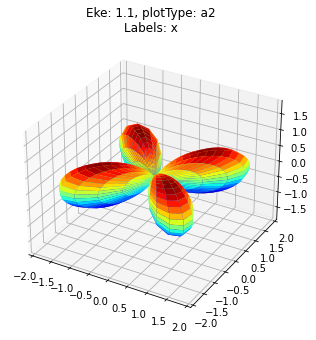

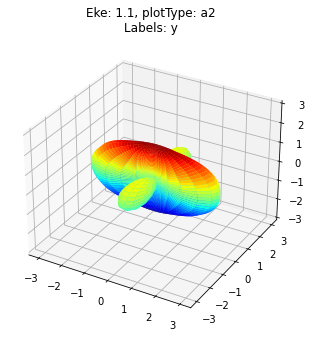

In [12]:
data.padPlot(keys = k, selDims={'Eke':[1.1]}, pType = 'a2')  # NOTE - currently need 'a2' for TX version, should set as default for this case!

Note here that the $x$ and $y$ components are different. This is correct *if* we only wanted to use a single orbital component. On the other hand, if we want the summed/symmetrized results then - for a cylindically symmetric system - we'd expect a cyllindrically symmetric result.

If we set `it=2`, we get results corresponding to the other (rotated) orbital component:

Summing over dims: {'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


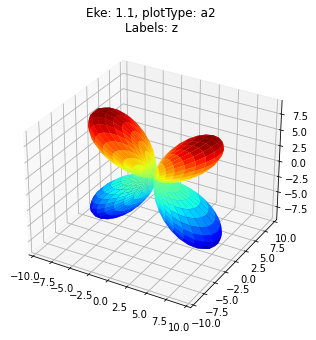

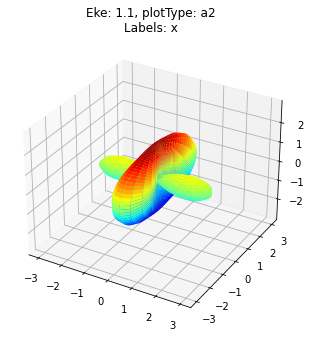

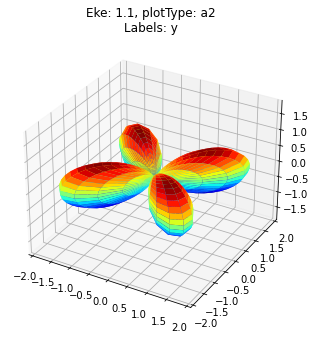

In [13]:
data.mfpadNumeric(keys = k, inds = {'Type':'L', 'it':2})
data.padPlot(keys = k, selDims={'Eke':[1.1]}, pType = 'a2') 

### Sum over degenerate components

We can also sum over these directly... but this may not give the expected result...

Summing over dims: {'it', 'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


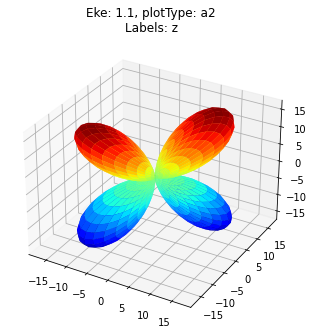

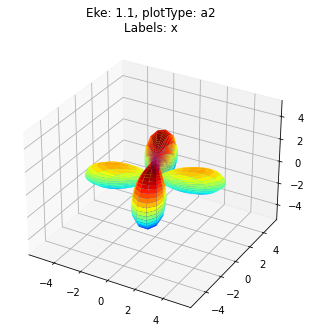

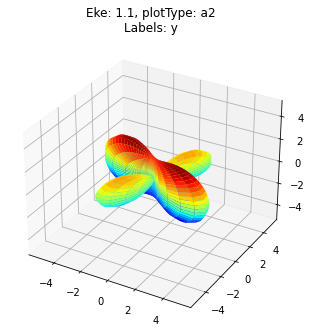

In [14]:
# Include it=1,2 components & sum
data.mfpadNumeric(keys = k, inds = {'Type':'L'})
data.padPlot(keys = k, selDims={'Eke':[1.1]}, pType = 'a2') 

This looks like a rotation, rather than a symmetrization, since the relative phases of the orbital components breaks the symmetry (there is still some extra phase-rotation present or, equivalently, the Cartesian axis definitions are mixed). This is clear in the imaginary values...

Summing over dims: {'it', 'Sym'}
Sph plots: Eke: 1.1, plotType: i
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


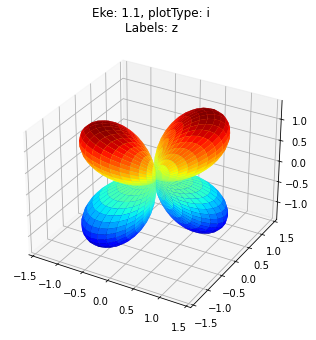

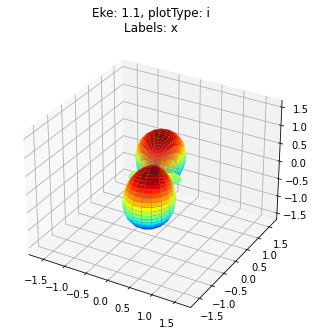

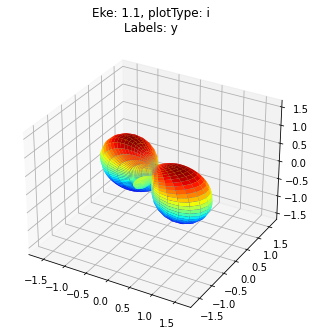

In [15]:
data.padPlot(keys = k, selDims={'Eke':[1.1]}, pType = 'i') 

### Further transformations of degenerate components

Finally, we can apply additional phase transformations to the numerical results... this is necessary to define the MFPADs for various special cases, e.g. if we want the result for an undefined alignment of the degenerate pair (sum over $\phi$), or multiple polarization geometries.

Note that while, in general, one could choose to modify the matrix elements directly - rather than the expanded distributions as here - we'll only explore the latter case herein.

#### (a) Sum over undefined/unaligned degenerate pair

In this case we'll define the MFPAD for the case where the degenerate pair alignment (equivalently the (x,y) axes) are not defined, hence we should expect a cylindrically-symmetric result.

Firstly, try a transformation of the `it=2` component only, as defined above for the matrix elements as $D_{2} = \Im D_{1} - i\Re D_{1}$.

Summing over dims: {'it', 'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


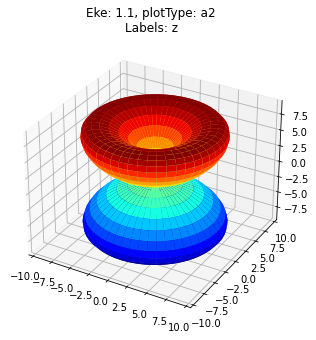

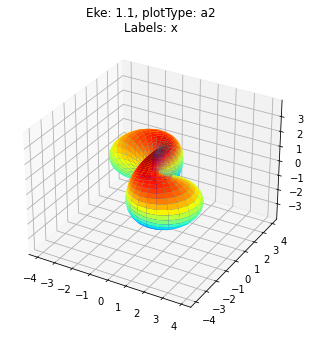

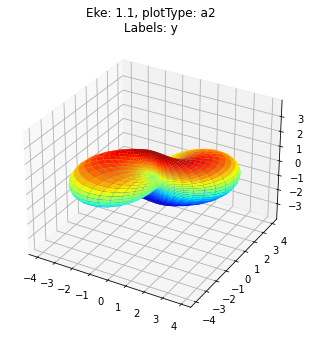

In [16]:
# Include it=1,2 components & sum
data.mfpadNumeric(keys = k, inds = {'Type':'L'})

# Set additional phase term for `it` component
phaseCorr = data.data[k]['matE']['it'].copy()
phaseCorr = phaseCorr.where(phaseCorr.it == 1, 1/1j)
# phaseCorr

data.data[k]['TX'] = data.data[k]['TX'] * phaseCorr

data.padPlot(keys = k, selDims={'Eke':[1.1]}, pType = 'a2') 

This case produces the correctly-symmetrize result for the z-pol case (i.e. averaged over all orbital component rotations $\phi$), but not for the (x,y) cases. This is because, as discussed above, additional frame rotations are involved in the latter, and the orientation of the electric field breaks the symmetry in this case.

For the (x,y) components we additionally need to coherently add the (x,y) components pair-wise. (There may be a simpler way to do this...?)

Summing over dims: {'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl


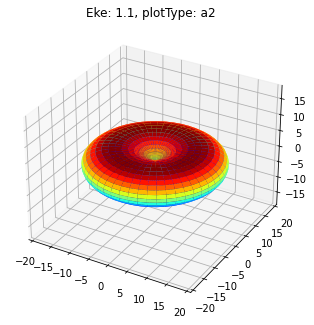

In [17]:
# Include it=1,2 components & sum
data.mfpadNumeric(keys = k, inds = {'Type':'L'})

# Use values directly
phaseCorr = data.data[k]['TX'].copy()
# phaseCorr = - phaseCorr.real - (1j * phaseCorr.imag) + phaseCorr.imag + (1j * phaseCorr.real)  # Not working as previously, tried all combinations!
                                                                                                # Needs additional subselection?
# phaseCorr = phaseCorr.sel(it=2).real - (1j * phaseCorr.sel(it=1).imag) + phaseCorr.sel(it=1).imag + (1j * phaseCorr.sel(it=2).real) # Better...

phaseCorr = phaseCorr.swap_dims({'Euler':'Labels'})

# This is symmetrized result = x+iy for BOTH components, with conj(it=2).
phaseCorr = phaseCorr.sel(it=1, Labels = 'x').real + (1j * phaseCorr.sel(it=1, Labels = 'y').imag) + \
            phaseCorr.sel(it=1, Labels = 'x').imag + (1j * phaseCorr.sel(it=1, Labels = 'y').real) + \
            (phaseCorr.sel(it=2, Labels = 'y').real + (1j * phaseCorr.sel(it=2, Labels = 'x').imag) + \
            phaseCorr.sel(it=2, Labels = 'y').imag + (1j * phaseCorr.sel(it=2, Labels = 'x').real)).conj()

kc = 'phaseCorr'
data.data[kc] = data.data[k].copy()
data.data[kc]['TX'] = phaseCorr

# Plot
data.padPlot(keys = kc, selDims={'Eke':[1.1]}, pType='a2') 

Again this produces a correctly-symmetrized result.

#### (b) Sum over a set of polarization for all orbital components

Another common case is the sum over degenerate cases where we want the result for a specific orbital alignment and polarization, for all degenerate sets. This is what one actually expects from the direct sum, but - as we saw above - this can give, instead, a phase-rotated result due to mixed axis definitions.

Instead, we can form the summed result from a single component, by coherently adding components and setting each (x+iy) pair.

TODO: better way/full formalism here? Currently ad hoc.

Summing over dims: {'Sym'}
Sph plots: Eke: 1.1, plotType: a2
Plotting with mpl


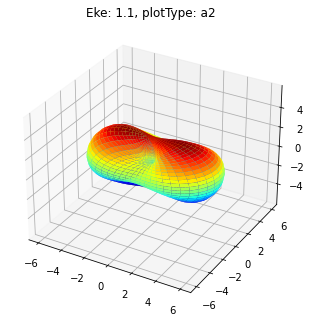

In [18]:
# Include it=1,2 components & sum
data.mfpadNumeric(keys = k, inds = {'Type':'L'})

phaseCorr = data.data[k]['TX'].copy()
phaseCorr = phaseCorr.swap_dims({'Euler':'Labels'})

# This is single orb component, but summed over (x,y) pol geoms
phaseCorr = phaseCorr.sel(it=1, Labels = 'x').real + (1j * phaseCorr.sel(it=1, Labels = 'y').imag) + \
            phaseCorr.sel(it=1, Labels = 'x').imag + (1j * phaseCorr.sel(it=1, Labels = 'y').real)

# phaseCorr = phaseCorr.sel(it=1, Labels = 'x') + phaseCorr.sel(it=1, Labels = 'y').conj()


kc = 'phaseCorr'
data.data[kc] = data.data[k].copy()
data.data[kc]['TX'] = phaseCorr

# Plot
data.padPlot(keys = kc, selDims={'Eke':[1.1]}, pType='a2') 
# data.padPlot(keys = kc, selDims={'Eke':[1.1]}, pType='r') 
# data.padPlot(keys = kc, selDims={'Eke':[1.1]}, pType='i') 

## MF $\beta_{LM}$

For direct calculation of the $\beta_{LM}$ parameters, a [fully-symmetrized formalism is used](../demos/ePSproc_BLM_calc_demo_Sept2019.html). In principle this should correctly treat some of the special cases discussed above for the numerical MFPADs, but also requires some care.


### Default case - single `it` component

As for the MFPAD numerical routine, the MFBLM routine defaults to a single component, `it=1`

In [19]:
# Compute AF-BLMs with default parameters (==LF case with isotropic axis distribution)
data.MFBLM(keys = k)


Calculating MF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Return type BLM.


In [20]:
data.data[k]['MFBLM'].coords

Coordinates:
    Euler    (Labels) object (0.0, 0.0, 0.0) ... (1.5707963267948963, 1.5707963267948966, 0.0)
  * Labels   (Labels) <U32 'z' 'x' 'y'
    Ehv      (Eke) float64 17.2 18.2 19.2 20.2 21.2 ... 63.2 64.2 65.2 66.2 67.2
    Type     <U1 'L'
  * Eke      (Eke) float64 0.1 1.1 2.1 3.1 4.1 5.1 ... 46.1 47.1 48.1 49.1 50.1
    it       int64 1
    SF       (Eke) complex128 (2.1560627+3.741674j) ... (4.4127053+1.8281945j)
    XS       (Labels, Eke) complex128 (10.957808663217225+0j) ... (0.38622094754079767+7.703719777548943e-34j)
  * BLM      (BLM) MultiIndex
  - l        (BLM) int64 0 0 0 0 0 2 2 2 2 2 4 4 4 4 4 6 6 6 6 6 8 8 8 8 8
  - m        (BLM) int64 0 -2 2 -4 4 0 -2 2 -4 4 0 ... 4 0 -2 2 -4 4 0 -2 2 -4 4

As before, note `it=1` only in the coordinates for the results.

Dataset: orb6, 1piu-1, MFBLM


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


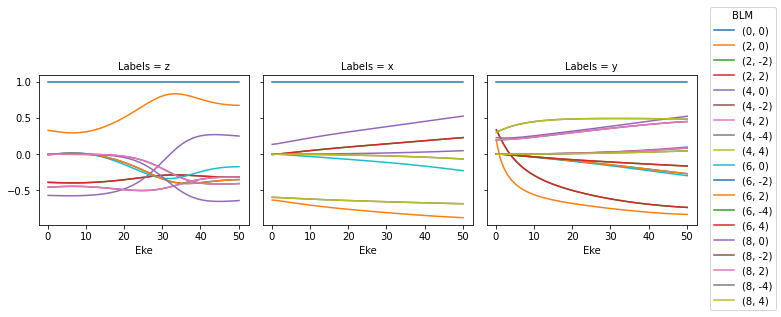

In [21]:
data.BLMplot(keys = k, dataType='MFBLM', thres = 1e-2)

In [22]:
# Check imaginary values are OK
data.data[k]['MFBLM'].imag.max()

<xarray.DataArray ()>
array(2.84473457e-16)
Coordinates:
    Type     <U1 'L'
    it       int64 1

In this case we have the MF $\beta_{LM}$ paramters directly. Note that these are real by definition here, so checking for non-zero imaginary parts is a useful quick test that everything is OK.

We can also visualise the corresponding MFPADs with padPlot().

Using default sph betas.
Summing over dims: set()
Sph plots: Eke: 1.1, plotType: a
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


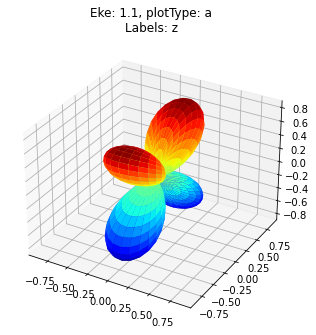

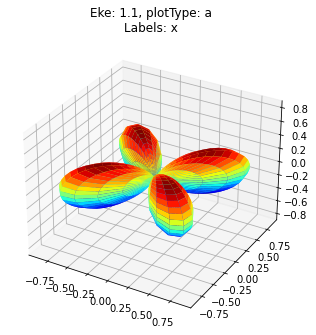

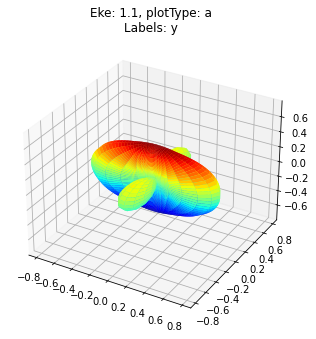

In [23]:
# Check MFPADs
data.padPlot(keys = k, selDims={'Eke':[1.1]}, dataType='MFBLM')
# selDims={'Eke':[1.1]}, pType='a'

These are identical in shape to the corresponding MFPAD calculation, but note that the total cross-section (==$\beta_{0,0}$) is normalised to unity in the default case, hence the smaller axis values.

We can check the absolute XS values too:

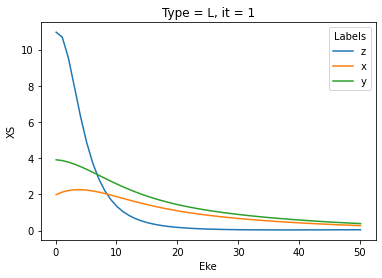

In [24]:
# Check absolute cross-sections
data.data[k]['MFBLM']['XS'].real.plot.line(x='Eke');

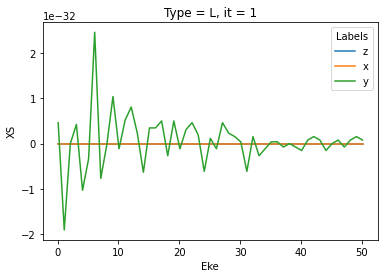

In [25]:
# Check absolute cross-sections, imag values
data.data[k]['MFBLM']['XS'].imag.plot.line(x='Eke');

### Both `it` components

Here's the same calculation for both components with a comparison:


Calculating MF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Return type BLM.
Dataset: orb6, 1piu-1, MFBLM


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


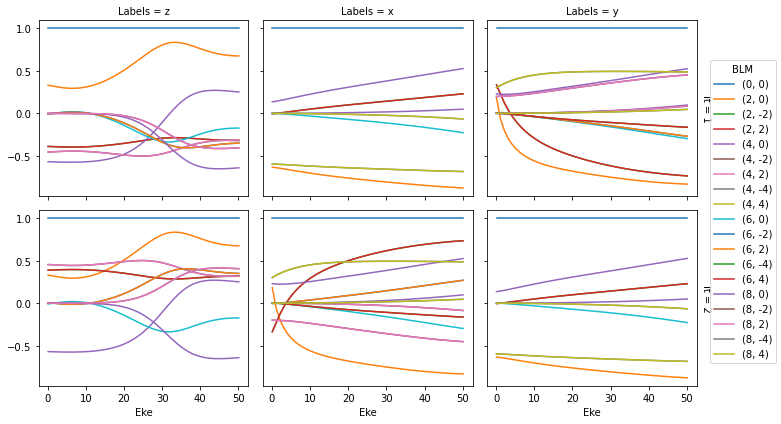

In [26]:
# data.MFBLM(keys = k, selDims = {'Type':'L', 'it':2})
data.MFBLM(keys = k, selDims = {'Type':'L'})

data.BLMplot(keys = k, dataType='MFBLM', thres = 1e-2, row = 'it')

In [27]:
# Check imaginary values are OK
data.data[k]['MFBLM'].imag.max()

<xarray.DataArray ()>
array(3.93960409e-16)
Coordinates:
    Type     <U1 'L'

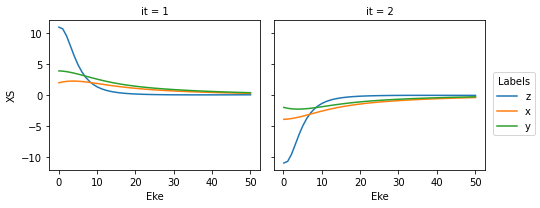

In [28]:
# Check absolute cross-sections
data.data[k]['MFBLM']['XS'].real.plot.line(x='Eke', col='it');

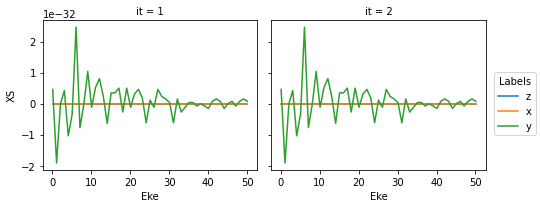

In [29]:
# Check absolute cross-sections, imag values
data.data[k]['MFBLM']['XS'].imag.plot.line(x='Eke', col='it');

Here it is clear that:

- The (x,y) components are switched, as we saw previously, and the the z components are different.
- The absolute XS are inverted for `it=2`, which is unphysical (-ve XS).
- The imaginary components are well-behaved.

The -ve XS values here point to the different phase-rotation of the 2nd degenerate component, which is not accounted for the formalism, although it does give the correct MFPADs when normalised. (This point is [explored further below for the AF/LF case](#Unaligned-(isotropic)-AF/LF-case).)

Here's the corresponding MFPADs for `it=2` for reference:

Using default sph betas.
Summing over dims: set()
Sph plots: Eke: 1.1, plotType: a
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


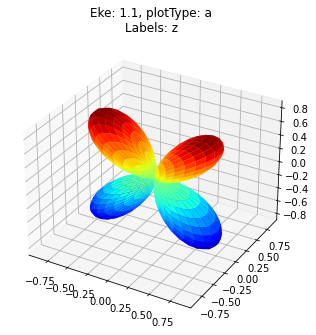

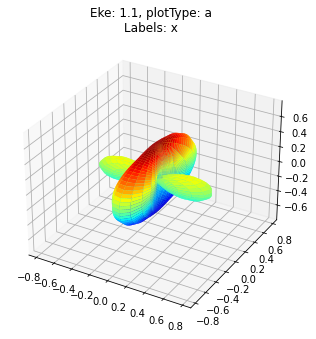

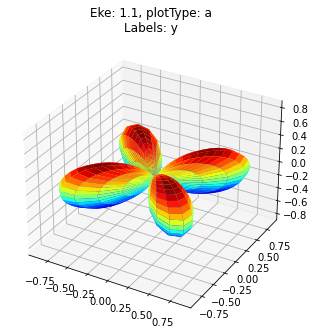

In [30]:
data.padPlot(keys = k, selDims={'Eke':[1.1], 'it':2}, dataType='MFBLM')

As before, `it=2` gives the same results, but rotated. OK.

### Summing over components

As for the numeric case, summing directly over components may, or may not, give the results/cases expected!

Options here are:

1. Coherent summation within the formalism (essentially coherent summation).
2. Summation of $\beta_{LM}$ parameters (essentially incoherent summation).
3. Further phase transformations etc. as explored previously.

#### Coherent sum


Calculating MF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Return type BLM.
Dataset: orb6, 1piu-1, MFBLM


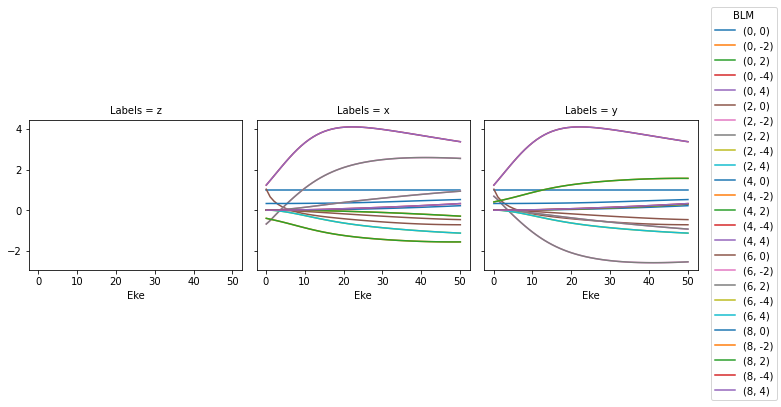

In [31]:
data.MFBLM(keys = k, selDims = {'Type':'L'}, sumDims = ['mu', 'mup', 'l','lp','m','mp', 'it']) # Cancels out z-component, symmetrized but odd 
data.BLMplot(keys = k, dataType='MFBLM', thres = None)

In [32]:
data.data[k]['MFBLM'].imag.max()

<xarray.DataArray ()>
array(2.33769645e-15)
Coordinates:
    Type     <U1 'L'

This gives some (x,y) output, but the z-pol case has cancelled out due to the phase rotation in the original definitions/matrix elements.

Note, also, that the output values have no significant imaginary part.

Here are the corresponding PADs:

Using default sph betas.
Summing over dims: set()
Sph plots: Eke: 1.1, plotType: a
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


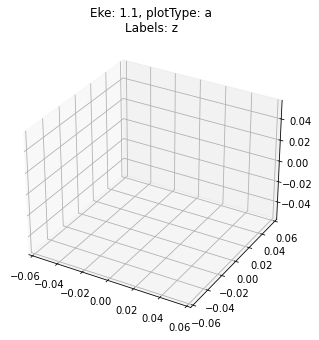

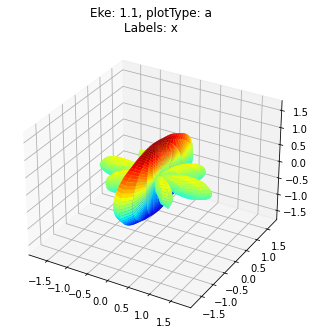

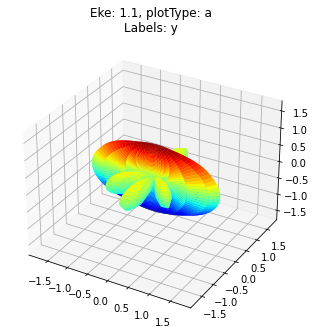

In [33]:
data.padPlot(keys = k, selDims={'Eke':[1.1]}, dataType='MFBLM')

Hmmm, interesting... in this case the (x,y) components are sort-of symmetrized (rather than rotated), but things are still not quite correct. As before, this is related to missing/different definitions in the formalism for the phase-rotated orbital components.

We can try fixing the phases manually as before...


Calculating MF-BLMs for job key: corrected


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Return type BLM.
Dataset: corrected, 1piu-1, MFBLM


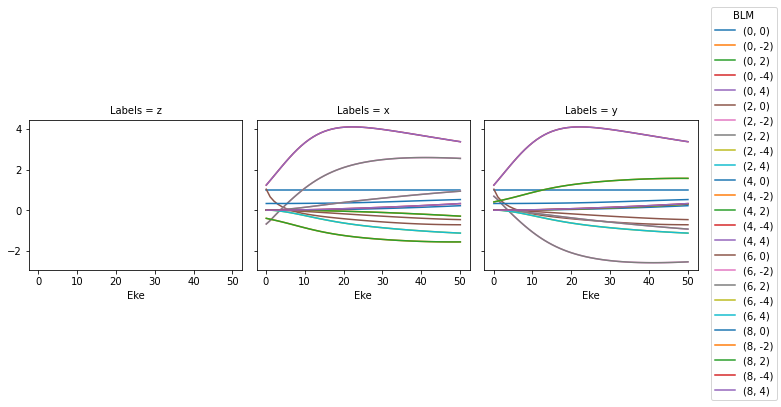

In [34]:
# Set test matrix elements
kc = 'corrected'
data.data[kc] = data.data[k].copy()

data.data[kc]['matE'] = data.data[kc]['matE'].copy()

# Set additional phase term
phaseCorr = data.data[kc]['matE']['it'].copy()
# phaseCorr = phaseCorr.where(phaseCorr.it == 1, 1/1j)
phaseCorr = phaseCorr.where(phaseCorr.it == 1, -1/1j)
# phaseCorr

# Multiply by phase term & calculate AF

data.data[kc]['matE'] = data.data[kc]['matE'] * phaseCorr
data.MFBLM(keys = kc, selDims = {'Type':'L'}, sumDims = ['mu', 'mup', 'l','lp','m','mp', 'it']) # Cancels out z-component, symmetrized but odd 
# data.MFBLM(keys = kc, selDims = {'Type':'L'})

data.BLMplot(keys = kc, dataType='MFBLM', thres = None)
# data.BLMplot(keys = kc, dataType='MFBLM', thres = None, row = 'it')

In [35]:
data.data[kc]['MFBLM'].imag.max()

<xarray.DataArray ()>
array(2.33769645e-15)
Coordinates:
    Type     <U1 'L'

Using default sph betas.
Summing over dims: set()
Sph plots: Eke: 1.1, plotType: a
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


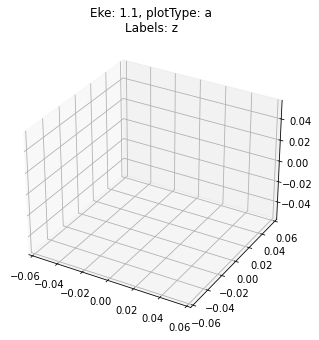

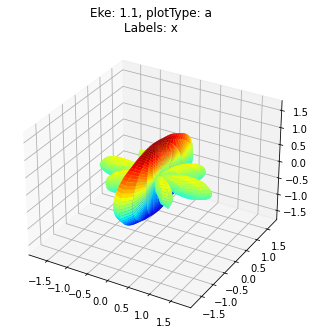

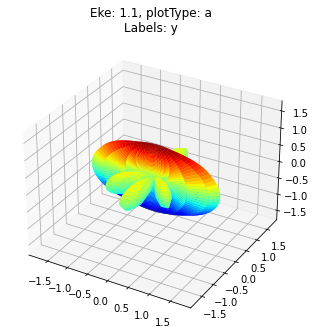

In [36]:
data.padPlot(keys = kc, selDims={'Eke':[1.1]}, dataType='MFBLM')

Hmmmm, still not correct - work in progress to fix!

#### Incoherent sum

Computing for both components, then adding the resulting MFPADs, gives the incoherent sum in this case (as distinct from the MFPAD numeric case). This is generally not what one wants, although might actually work in some cases.

In [37]:
# data.BLMplot(keys = k, dataType='MFBLM', thres = 1e-2)
data.MFBLM(keys = k, selDims = {'Type':'L'})
# data.BLMplot(keys = k, dataType='MFBLM', thres = 1e-2)  #, row = 'it')


Calculating MF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Return type BLM.


Using default sph betas.
Summing over dims: {'it'}
Sph plots: Eke: 1.1, plotType: a
Plotting with mpl
Data dims: ('Labels', 'Phi', 'Theta'), subplots on Labels


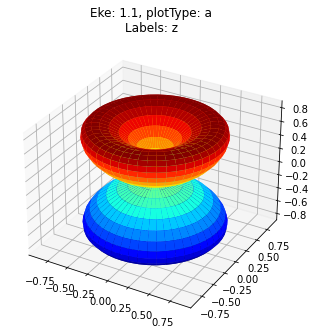

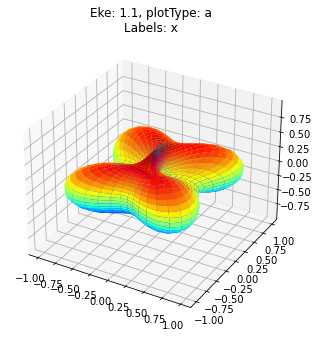

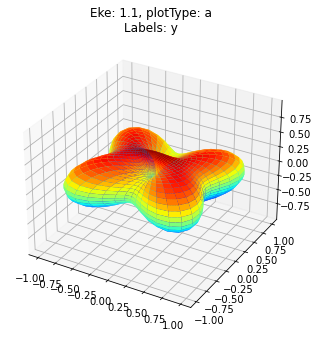

In [38]:
data.padPlot(keys = k, selDims={'Eke':[1.1]}, dataType='MFBLM')

Here the z-pol case is correctly symmetrized in the incoherent case, while the (x,y) cases - again due to phase/rotation effects - are not.

### Unaligned (isotropic) AF/LF case

For direct calculation of the AF $\beta_{LM}$ parameters, a [fully-symmetrized formalism is used](../methods/geometric_method_dev_pt3_AFBLM_090620_010920_dev_bk100920.html), similar to the MF case. In principle this should correctly treat all cases, since there are no additional frame transformations in this case (provided that the polarization and alignment reference frames are consistently defined). For an isotropic molecular axis distribution, the AF case is identical to the standard LF treatment.

#### Default case - single `it` component with degeneracy included

Firstly, let's check the isotropic case with the default settings. As of [commit 2153b31](https://github.com/phockett/ePSproc/commit/2153b3139a3b7cabad8e14695e0981b4303683db) (6th August 2021) this includes a degeneracy factor.

(In this case the results can be verified against the LF results output directly from ePS, via the `GetCro` routine. For more about this, see [the ePS tutorial](ePS_tutorial_080520.html#Results).)

In [39]:
# Compute AF-BLMs with default parameters (==LF case with isotropic axis distribution)
data.AFBLM(keys = k)


Calculating AF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [40]:
# Note the default cases selects it=1 only!
# In particular, the code has defaults selDims = {'Type':'L', 'it':1}
data.data[k]['AFBLM'].coords

Coordinates:
    Euler       (Labels) object (0.0, 0.0, 0.0)
  * Labels      (Labels) <U1 'A'
  * t           (t) int64 0
    Ehv         (Eke) float64 17.2 18.2 19.2 20.2 21.2 ... 64.2 65.2 66.2 67.2
    Type        <U1 'L'
  * Eke         (Eke) float64 0.1 1.1 2.1 3.1 4.1 ... 46.1 47.1 48.1 49.1 50.1
    it          int64 1
    SF          (Eke) complex128 (2.1560627+3.741674j) ... (4.4127053+1.8281945j)
    XSraw       (Labels, t, Eke) complex128 (11.238380842732697+0j) ... (0.47192918168427883+0j)
    XSrescaled  (Labels, t, Eke) complex128 (39.83902280528869+0j) ... (1.6729453908619778+0j)
    XSiso       (Eke) complex128 (19.919511415560077+0j) ... (0.8379214361922648+0j)
  * BLM         (BLM) MultiIndex
  - l           (BLM) int64 0 2
  - m           (BLM) int64 0 0

Dataset: orb6, 1piu-1, AFBLM


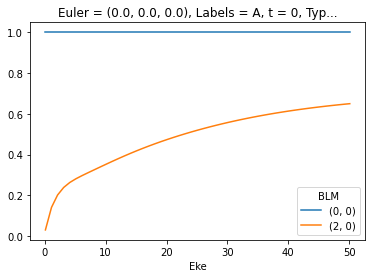

In [41]:
# Plot AFBLM outputs
data.BLMplot(keys = k, col=[])  # TODO - update defaults from None to []!

Dataset: orb6, 1piu-1, AFBLM


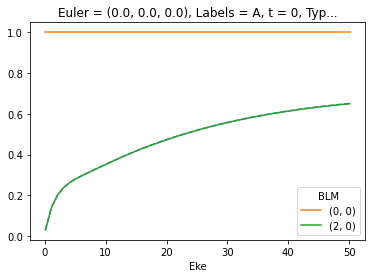

In [42]:
# For reference, add the orignial ePolyScat GetCro outputs, which also give the LF betas
# (Note conversion to spherical harmonic form)
data.data[k]['XSconv'] = ep.conversion.conv_BL_BLM(data.data[k]['XS'], to='sph')
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'BETA', 'Sym':'All'}).plot.line(x='Eke', linestyle='dashed');

# Plot AFBLM outputs
data.BLMplot(keys = k, col=[])  # TODO - update defaults from None to []!

# plt.legend(['AFBLM', 'GetCro'])

OK, this looks good for $\beta_2$ values (dashed line shows ref. values). Note, however, that there are a few things going on behind the scenes, in particular the routine selects `it=1` by default, and also normalises by the $\beta_0$ values - this can hide some issues.

Let's take a closer look at the output values for the XS (cross-section).

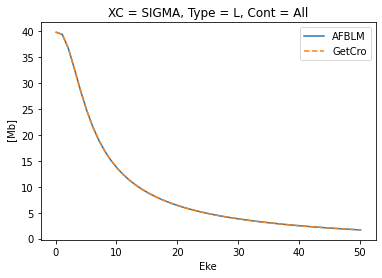

In [43]:
# Check absolute cross-sections
data.data[k]['AFBLM']['XSrescaled'].real.plot()
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'SIGMA', 'Sym':'All'}).real.plot(linestyle='dashed');
plt.legend(['AFBLM', 'GetCro'])

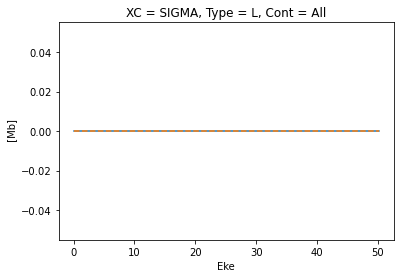

In [44]:
# Check absolute cross-sections, imag values
data.data[k]['AFBLM']['XSrescaled'].imag.plot()
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'SIGMA', 'Sym':'All'}).imag.plot(linestyle='dashed');

Here we see that: 

- <del>There is a factor of 2 discrepancy in the absoluted XS, which is due to the missing degeneracy factor.</del> As of [commit 2153b31](https://github.com/phockett/ePSproc/commit/2153b3139a3b7cabad8e14695e0981b4303683db) the XS is correct (note, however, that previous versions do not include a degeneracy factor).
- Imaginary values are zero, as they should be for this observable.

#### Switching `it` component

Next, let's look at the results if we decide to set `it=2`.

In [45]:
# Compute AF-BLMs with default parameters (==LF case with isotropic axis distribution)
data.AFBLM(keys = k, selDims = {'Type':'L', 'it':2})


Calculating AF-BLMs for job key: orb6


/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/paul/anaconda3/envs/epsdev-xr13/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [46]:
# Check coords in output
data.data[k]['AFBLM'].coords

Coordinates:
    Euler       (Labels) object (0.0, 0.0, 0.0)
  * Labels      (Labels) <U1 'A'
  * t           (t) int64 0
    Ehv         (Eke) float64 17.2 18.2 19.2 20.2 21.2 ... 64.2 65.2 66.2 67.2
    Type        <U1 'L'
  * Eke         (Eke) float64 0.1 1.1 2.1 3.1 4.1 ... 46.1 47.1 48.1 49.1 50.1
    it          int64 2
    SF          (Eke) complex128 (2.1560627+3.741674j) ... (4.4127053+1.8281945j)
    XSraw       (Labels, t, Eke) complex128 (-5.619190421366349+0j) ... (-0.23596459084213942+0j)
    XSrescaled  (Labels, t, Eke) complex128 (-19.919511402644346+0j) ... (-0.8364726954309889+0j)
    XSiso       (Eke) complex128 (19.919511415560077+0j) ... (0.8379214361922648+0j)
  * BLM         (BLM) MultiIndex
  - l           (BLM) int64 0 2
  - m           (BLM) int64 0 0

Dataset: orb6, 1piu-1, AFBLM


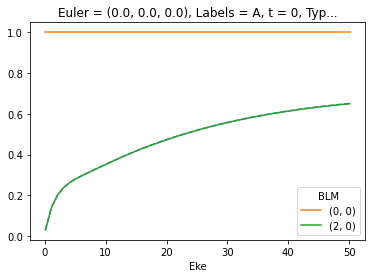

In [47]:
# For reference, add the orignial ePolyScat GetCro outputs, which also give the LF betas
# (Note conversion to spherical harmonic form)
data.data[k]['XSconv'] = ep.conversion.conv_BL_BLM(data.data[k]['XS'], to='sph')
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'BETA', 'Sym':'All'}).plot.line(x='Eke', linestyle='dashed');

# Plot AFBLM outputs
data.BLMplot(keys = k, col=[])  # TODO - update defaults from None to []!

Normalised values look good... what about the absolute XS?

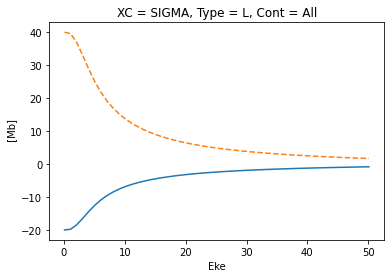

In [48]:
# Check absolute cross-sections
data.data[k]['AFBLM']['XSrescaled'].real.plot()
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'SIGMA', 'Sym':'All'}).real.plot(linestyle='dashed');

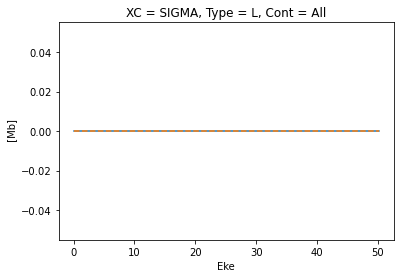

In [49]:
# Check absolute cross-sections, imag values
data.data[k]['AFBLM']['XSrescaled'].imag.plot()
data.data[k]['XSconv'].sel({'Type':'L', 'XC':'SIGMA', 'Sym':'All'}).imag.plot(linestyle='dashed');

Hmmm, here we see:

- Negative XS! Definitely not correct.
- Imaginary values are zero, OK.

Why is this? In this case, similarly to the MF case above, the formalism has a specific axis definition, but we've introduced an additional phase rotation with the `it=2` component which is not accounted for in the standard treatment.

#### AF case summary

The general conclusion here is that the XS and normalised $\beta$ values are correct when a single `it=1` component is selected; for other cases a phase correction, is required to get the correct absolute XS for other cases.

TODO: testing with non-isotropic distributions (in progress).

## Versions

In [72]:
import scooby
scooby.Report(additional=['epsproc', 'xarray', 'jupyter'])

--------------------------------------------------------------------------------
  Date: Mon Aug 09 11:24:25 2021 EDT

                OS : Linux
            CPU(s) : 64
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.7.10 (default, Feb 26 2021, 18:47:35)  [GCC 7.3.0]

           epsproc : 1.3.0-dev
            xarray : 0.13.0
           jupyter : Version unknown
             numpy : 1.20.1
             scipy : 1.6.1
           IPython : 7.21.0
        matplotlib : 3.3.4
            scooby : 0.5.6
--------------------------------------------------------------------------------

In [73]:
# Check current Git commit for local ePSproc version
!git -C {Path(ep.__file__).parent} branch
!git -C {Path(ep.__file__).parent} log --format="%H" -n 1

* dev
  master
3970b58024ddc7c430bf73702ecb0c08a0fb5a66


In [74]:
# Check current remote commits
!git ls-remote --heads git://github.com/phockett/ePSproc

3970b58024ddc7c430bf73702ecb0c08a0fb5a66	refs/heads/dev
82d12cf35b19882d4e9a2cde3d4009fe679cfaee	refs/heads/master
69cd89ce5bc0ad6d465a4bd8df6fba15d3fd1aee	refs/heads/numba-tests
ea30878c842f09d525fbf39fa269fa2302a13b57	refs/heads/revert-9-master
